In [1]:
%pip install opencv-python
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\VscodeFiles\PYTHON\QUIZ\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\VscodeFiles\PYTHON\QUIZ\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\VscodeFiles\PYTHON\QUIZ\env\Scripts\python.exe -m pip install --upgrade pip' command.


Ângulo 1: 104.28 graus
Ângulo 2: 38.72 graus
Ângulo 3: 37.00 graus
276.8247351412457
Horário detectado: 09:44


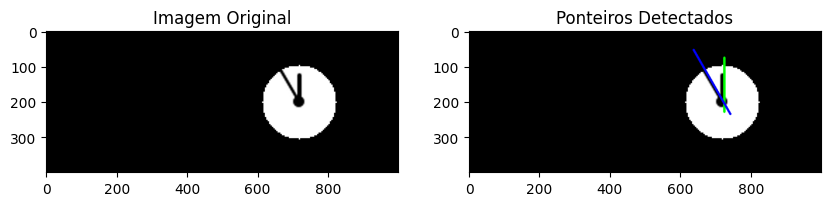

Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "clock_1.png"

imagem = cv2.imread(image_path, cv2.IMREAD_COLOR)

cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

suave = cv2.medianBlur(cinza, 5)

circulos = cv2.HoughCircles(
    suave,
    cv2.HOUGH_GRADIENT,
    dp=1.2,  
    minDist=40,  
    param1=50,  
    param2=30,  
    minRadius=15,  
    maxRadius=60,  
)

vertices = []

if circulos is not None:
    circulos = np.round(circulos[0, :]).astype("int")

    x, y, raio = circulos[0]

    mask = np.zeros_like(cinza)
    cv2.circle(mask, (x, y), int(raio * 0.70), 255, -1)

    masked_image = cv2.bitwise_and(imagem, imagem, mask=mask)

    x1, y1 = x - int(raio * 0.80), y - int(raio * 0.80)
    x2, y2 = x + int(raio * 0.80), y + int(raio * 0.80)
    cropped_image = masked_image[y1:y2, x1:x2]

    scale_factor = 4  
    width = int(imagem.shape[1] * scale_factor)
    height = int(imagem.shape[0] * scale_factor)
    high_quality_image = cv2.resize(imagem, (width, height), interpolation=cv2.INTER_CUBIC)
    high_quality_gray = cv2.cvtColor(high_quality_image, cv2.COLOR_BGR2GRAY)
    high_quality_mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    high_quality_masked_image = cv2.bitwise_and(high_quality_image, high_quality_image, mask=high_quality_mask)

    gray = cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 75, 200, apertureSize=3)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=45, minLineLength=30, maxLineGap=10
    )

    line_image = np.copy(high_quality_masked_image)

    longest_line_minute = None
    max_length_minute = 0
    longest_line_hour = None
    max_length_hour = 0

    def line_length(x1, y1, x2, y2):
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def calculate_angle(x1, y1, x2, y2, cx, cy):
        angle = np.arctan2(y2 - cy, x2 - cx) - np.arctan2(y1 - cy, x1 - cx)
        angle = np.degrees(angle)
        if angle < 0:
            angle += 360
        return angle

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = line_length(x1, y1, x2, y2)
            thickness = cv2.norm(gray[y1:y2, x1:x2], cv2.NORM_L2) / length

            if thickness > 10:
                if length > max_length_hour:
                    max_length_hour = length
                    longest_line_hour = (x1, y1, x2, y2)
            else:
                if length > max_length_minute:
                    max_length_minute = length
                    longest_line_minute = (x1, y1, x2, y2)

        if longest_line_minute is not None:
            x1, y1, x2, y2 = longest_line_minute
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
            new_length = length * 1.8  
            x1_new = int(x1 - direction_vector[0] * (new_length - length))
            y1_new = int(y1 - direction_vector[1] * (new_length - length))
            x2_new = int(x2 + direction_vector[0] * (new_length - length))
            y2_new = int(y2 + direction_vector[1] * (new_length - length))
            cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 5)
            vertices.append((x1, y1))
            vertices.append((x2, y2))

        if longest_line_hour is not None:
            x1, y1, x2, y2 = longest_line_hour
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
            new_length = length * 1.8 
            x1_new = int(x1 - direction_vector[0] * (new_length - length))
            y1_new = int(y1 - direction_vector[1] * (new_length - length))
            x2_new = int(x2 + direction_vector[0] * (new_length - length))
            y2_new = int(y2 + direction_vector[1] * (new_length - length))
            cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (255, 0, 0), 5)
            vertices.append((x1, y1))
            vertices.append((x2, y2))

        if len(vertices) >= 3:
            def angle_between_points(p1, p2, p3):
                v1 = np.array(p1) - np.array(p2)
                v2 = np.array(p3) - np.array(p2)
                angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
                return angle

            angle1 = angle_between_points(vertices[0], vertices[1], vertices[2])
            angle2 = angle_between_points(vertices[1], vertices[2], vertices[0])
            angle3 = 180.0 - angle1 - angle2 

            print(f"Ângulo 1: {angle1:.2f} graus")
            print(f"Ângulo 2: {angle2:.2f} graus")
            print(f"Ângulo 3: {angle3:.2f} graus")
        else:
            print("Não há vértices suficientes para formar um triângulo.")

        def adjust_angle(angle):
            adjusted_angle = (angle - 90) % 360
            return adjusted_angle if adjusted_angle >= 0 else adjusted_angle + 360

        hour_angle = calculate_angle(*longest_line_hour, x, y) if longest_line_hour else 0
        minute_angle = calculate_angle(*longest_line_minute, x, y) if longest_line_minute else 0

        adjusted_hour_angle = adjust_angle(hour_angle)
        adjusted_minute_angle = adjust_angle(minute_angle)

        print(adjusted_hour_angle)
        hour = int(adjusted_hour_angle / 30)
        minute = int(adjusted_minute_angle / 6)

        print(f"Horário detectado: {hour:02d}:{minute:02d}")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Imagem Original")
    plt.imshow(cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Ponteiros Detectados")
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

    plt.show()

    print("Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png")
else:
    print("Nenhum círculo detectado")


Ângulo dos minutos (linha verde): 308.47 graus
Ângulo das horas (linha azul): 7.49 graus
Ângulo 1: 111.87 graus
Ângulo 2: 34.34 graus
Ângulo 3: 33.78 graus
339.8367680413581
Horário detectado: 09:48


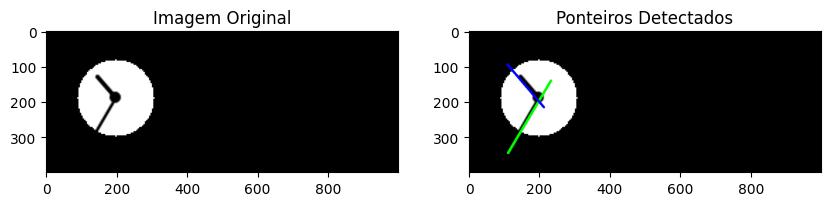

Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO

base64_str = "iVBORw0KGgoAAAANSUhEUgAAAPoAAABkCAYAAACvgC0OAAAMz0lEQVR4Xu2dXYhVVRvHNctxrMDCjxwUtEyZwFRMSOkquwjEC/XCErwRDEsEdS4kIgXJbgrFmEnRi0nU8iK/QBD0QkMwQ73yxiAUjQgjw9GxRp1aL78N67xrr5mzz/fea5/z/8Hi6Nn77P08D/s/a6+vZ40wQoimZ4T/hRCi+ZDQhWgBJHQhWgAJXYgWIHih9/f3m0uXLpne3l6zZcsWs2zZMrNw4UIzbdq0qLS3t5sRI0ZEn/Y7jnMe5/M7fs91hGhVghP6o0ePzLlz58ynn35q3nrrLfPMM89EQq61cB2ux3W5PvcRolUIRugXL14069atMy+++OIQkTaicB/ux32FaHYyFfrDhw/Nrl27zIwZM4YI0S1z5841K1euNFu3bjVHjhyJxHnz5s2o/PPPP9G1+LTfcZzzOJ/f8Xv/mm7h/tiBPUI0I5kIva+vz3z++edmwoQJQ0RHmT59uvnoo4/M999/b+7evev/vCq4DtfjulzfvycFe7AL+4RoJlIV+uDgoOnu7jYvvPDCEJGNGzfOfPDBB+bChQv+zxoC9+F+3Ne3BfuwE3uFaAZSE/pPP/1k5s+fP0RU1K579+41AwMD/k9Sgfty/+FqeezFbiHyTsOF/vjxY7Nx40bz1FNPxUQ0c+ZMc+DAAfPkyRP/J4m413A5efKkmTdvnhk7dqx54403zA8//BA7XgrswB7scu+B3diPH0LklYYKnY6xBQsWxISDEHfs2FHz8JYv9KVLl5orV65EHWr79+83HR0dsePlgl3Yh52u3fiBP0LkkYYJ/cSJE0Pav0uWLKmbWHyhu/zyyy/m1Vdf9b+uCOzEXtd+/MEvIfJGcbXUQE9Pjxk1alRBIKNHjza7d+/2T6uJYkL//fffo7b16dOn/UNVgd3Yb33BL/wTIk8Mr5YaYOzarQVffvnl6JV6OBjy+vLLL6saQhtO6HScMQX20KFD/qFEStmB/fjh+oWfQuSFoWqpgfXr18fEsGjRoqLigZ07d0bn8VkpvtD37dtnJk2aZM6cORP7vhzKsQM/8Mf1D3+FyAN1E7pfk9O+LTXTrFRNOhzuPWwp9v2DBw+8Xw9PuXbgj99uV80u8kBdhE6b1X34V61aVfGwWV7AL/xz/VWbXYROzUKnF9odI6fGa1aRW/DPrdnxX73xImRqEvqNGzdiQ2isAy/1ut4s4Cf+Wt+JA/EQIkSqFjoTS9zJMPRKl2rjNhv46/bGE49aJwIJ0QiqFvqmTZsKD3hbW5u5fPmyf0pLgN/4b2NBXIQIjaqEzni12y7/6quv/FNaCvx32+taCCNCo2Kh//vvv7FVaHRKCRPrnCM+xEmIUKhY6KzTtg80Cz/qNXc97xAHdyEMcRIiFCoSOplX3KQRrPIS/4d42NgQJ2WqEaFQkdBJs2QfZNZtq4c5DvFw17MTLyFCoGyhM27s5ngjSYNLudNIm4Vi/hIXGyPi1SrzCkTYlC10sqTaB5i0S/7st3IWhjQTxfwlLm5aKuImRNaULXQSOdiHlxxrPsVquEr45JNPog6tzZs3+4eCI8lf4mNjVWsCDCHqQVlCJ0+6fXCZ6mlzqdeb5557rnCfzz77zD+cG4iPOzVYm0SIrClL6B9++GHhoSVFcqMg57q9z8iRI83hw4f9U3IDcbK+ED8hsqSk0OlJdrdJamTedTKtvvPOO4V7MbW00myuoUCcrB/ETyMUIktKCp0NCe0DywKO//77zz+lrty7d8/Mnj07JpLr16/7pwUPcXIXvBBHIbKipNDZfdQ+rLxap8GtW7eidM3uH5g//vjDPy143KYIcRQiK0oKna2G7cPK3mVpcfXq1Vjn3Jtvvmn+/vtv/7SgIV7WfuIoRFYkCr2/v7+wPzmrsv7880//lIZy6tSpWNroFStW5GqxCPGyq/yII/EUIgsShe4Oq9FuzgI/H11XV5d/StC4/Q0aZhNZkSj0b775pvCQvvfee/7h1EDcrtjzlIyRuFm7iacQWZAo9I8//rjwkG7bts0/nBq8rvPabm3hdZ7X+jxA3KzdxFOILEgU+vLlywsP6bfffusfThU64uiQs/bQUUeHXegQN2sz8RQiCxKFzvbD9iENIT0SQ2zu2HR7e7uZOHGimTx5snn//ffNr7/+6v8kc4ibtZd4CpEFiUKfNWtW4SH9+eef/cOZwOQZf5dWW5hcE5rYiZu1j3gKkQWJQncnrfz222+xY2fPnjWvvfZa9ApNvrQ0h94WL148ROS2ULOnyfHjx82cOXOiVXfU2OfPn48dJ27Wtmr3bBeiVhKF/vzzzxce0vv378eOTZkyJeoQGxgYiD7Xrl0bO95I3D9AfklbTKtXr45qbfoQWIRDM8KFuFnbiKcQWZAodHeyyuDgYOwYDzQCZ7EGn1OnTo0dbyQhCd3CHzxmwr3++uux74mbtY14CpEFiUJPqtER94wZMwqJIsaMGRM73kh4PfcFbkvar+5g701CyB9//DF2TDW6CIFEoSe10V1op3Z2dvpfNww63Nyls7Zk2RlnX9354+eiNroIgUShl+p1ZyLLlStXonRJae/WYjPS8jr80ksvZTa8RoIJVtsh9O+++25IE0a97iIEEoWeNI7OdyzYeOWVV6LcaWkuNvnrr7/M+PHjIxuOHj3qH06VgwcPRmP7jD4sWrRoyHx2jaOLEEgUekgz41w2bNgQ2fT222/7h4JDM+NECCQKPZS57i7Xrl0zTz/9dFT4d+horrsIgUShh7J6zYVaHHuo1fOAVq+JEEgUegjr0V1oj2ML7XPa6XlA69FFCCQKPesMMy7kSp82bVpky549e/zDQaIMMyIUEoUOWeWM89m+fXtkw9y5c1Pt4a8F5YwToVBS6FlkgfW5ffu2efbZZ6NNHfKU511ZYEUolBR62nndh8N2aIXSIVgOyusuQqKk0NPcqWU4qMGpyanRqdnzgnZqESFRUuiQ1t5rPrTFaZNzX9roeUJ7r4mQKEvoae2m6kPvOvektz2te9YD7aYqQqMsoUMa+6O7hDSffTiS/NX+6CI0yhb6rl27Cg/v9OnTzZMnT2LHd+7cGR3jsx6EPp+9mL/EhfjYWBE3IbKmbKE/fPjQTJgwofAAHzhwIHY8qYarlDzMZy/mL3GxMSJexE2IrClb6GDXgFNmzpzZsJ7kvM1ntxAP4mJjRLyECIGKhN7X1xelS7IP8o4dO/xTaiaP89ktxMPGhjgRLyFCoCKhQ3d3d+FhJl/czZs3/VOqJo/z2S3EgXjY2BAnIUKhYqEztj1//vzCA01O93qRx/nsFuJgY0J88ma/aG4qFjqQHsmuyqLUI19cXuezA/7bWBAXP+2WEFlTldBh06ZNhYe7ra3NXL582T+lIr7++uvoWnmazw74jf82FsRFiNCoWuj0MC9YsKDwgLOAwx9qqgR+S7u8lmukDba6C1eIR6NGIoSohaqFDjdu3IhN9Vy4cGHLjBvjJ/5a34kD8RAiRGoSOpw4cSLWXqdTyp8112zgn9v5hv/EQYhQqVno0NPTU3joKatWrWpaseMX/rn+4r8QIVMXocPWrVtjDz81XqnX+GLTSNOmXDvwx63JKfgtROjUTeiwfv36mAjYuSRJPMUWhqRNOXbgB/64/uGvEHmgrkIHv2anV5r92Yaj3Jq0GExK+eKLL6KNDW0/QTWUsgP73d511eQib1SnjBLQZnX3Vh89erTZvXu3f1rNsAQUkTOW3aiZaNiN/dYX/FKbXOSNhggd6IV2h94otG/rOTee3UmPHTvmf10XsNNvj+OPetdFHmmY0AGxuJNqKCz8YJVXPSaWMCOtq6srmjpLJpfTp0/7p1QMdmGfu0CFgh/1/CMlRJo0VOjw+PFjs3HjxthYO4V12yRpqGUYrqOjw5w6dcoMDAxEn/y/WrADe9z15BTsxn78ECKvNFzoFhZ6uKvebCHtEjnWEGulrFmzJhI4tTCfU6ZM8U8pCffl/m76J1uwVwtURDOQmtBhcHAwWqftJq+whfYvKZIryRt/584d8+6770av7p2dnebs2bP+KUXhPtzP70egYB92Yq8QzUCqQreQeYU0S24OOrdQu7KdEXuXFRvyqhSuw/W47nC1NwV7sEuZYUSzkYnQLcw0s0NkvujcQiKKlStXRmPXR44cifKk0zFGsfne+bTfcZzzOJ/f2U0gihXujx2lZvIJkVcyFboL4ly3bl1s+6dGFu7D/bS5gmgFghG6hY41NiRk91G2Grb7s9dauA7X47pcvx7De0LkheCE7tPf328uXbpkent7zZYtW8yyZcuideAkkaS0t7dHQubTfsdxzuN8fsfvuY4QrUrwQhdC1I6ELkQLIKEL0QJI6EK0ABK6EC2AhC5ECyChC9ECSOhCtAASuhAtgIQuRAvwP0ZNQLVsqNWQAAAAAElFTkSuQmCC"

def clockReader(base64_str):
    base64_bytes = base64.b64decode(base64_str)
    image_buffer = BytesIO(base64_bytes)
    imagem = cv2.imdecode(np.frombuffer(image_buffer.read(), np.uint8), cv2.IMREAD_COLOR)

    cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    suave = cv2.medianBlur(cinza, 5)

    circulos = cv2.HoughCircles(
        suave,
        cv2.HOUGH_GRADIENT,
        dp=1.2,  
        minDist=40,  
        param1=50,  
        param2=30,  
        minRadius=15,  
        maxRadius=60,  
    )

    vertices = []

    if circulos is not None:
        circulos = np.round(circulos[0, :]).astype("int")

        x, y, raio = circulos[0]

        mask = np.zeros_like(cinza)
        cv2.circle(mask, (x, y), int(raio * 0.70), 255, -1)

        masked_image = cv2.bitwise_and(imagem, imagem, mask=mask)

        x1, y1 = x - int(raio * 0.80), y - int(raio * 0.80)
        x2, y2 = x + int(raio * 0.80), y + int(raio * 0.80)
        cropped_image = masked_image[y1:y2, x1:x2]

        scale_factor = 4  
        width = int(imagem.shape[1] * scale_factor)
        height = int(imagem.shape[0] * scale_factor)
        high_quality_image = cv2.resize(imagem, (width, height), interpolation=cv2.INTER_CUBIC)
        high_quality_gray = cv2.cvtColor(high_quality_image, cv2.COLOR_BGR2GRAY)
        high_quality_mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
        high_quality_masked_image = cv2.bitwise_and(high_quality_image, high_quality_image, mask=high_quality_mask)

        gray = cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2GRAY)

        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        edges = cv2.Canny(blurred, 75, 200, apertureSize=3)

        lines = cv2.HoughLinesP(
            edges, 1, np.pi / 180, threshold=45, minLineLength=30, maxLineGap=10
        )

        line_image = np.copy(high_quality_masked_image)

        longest_line_minute = None
        max_length_minute = 0
        longest_line_hour = None
        max_length_hour = 0

        def line_length(x1, y1, x2, y2):
            return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        def calculate_angle(x1, y1, x2, y2, cx, cy):
            angle = np.arctan2(y2 - cy, x2 - cx) - np.arctan2(y1 - cy, x1 - cx)
            angle = np.degrees(angle)
            if angle < 0:
                angle += 360
            return angle

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                length = line_length(x1, y1, x2, y2)
                thickness = cv2.norm(gray[y1:y2, x1:x2], cv2.NORM_L2) / length

                if thickness > 10:
                    if length > max_length_hour:
                        max_length_hour = length
                        longest_line_hour = (x1, y1, x2, y2)
                else:
                    if length > max_length_minute:
                        max_length_minute = length
                        longest_line_minute = (x1, y1, x2, y2)

            if longest_line_minute is not None:
                x1, y1, x2, y2 = longest_line_minute
                length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
                new_length = length * 1.8  
                x1_new = int(x1 - direction_vector[0] * (new_length - length))
                y1_new = int(y1 - direction_vector[1] * (new_length - length))
                x2_new = int(x2 + direction_vector[0] * (new_length - length))
                y2_new = int(y2 + direction_vector[1] * (new_length - length))
                cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 5)
                vertices.append((x1, y1))
                vertices.append((x2, y2))

                minute_angle = calculate_angle(x1_new, y1_new, x2_new, y2_new, x, y)
                print(f"Ângulo dos minutos (linha verde): {minute_angle:.2f} graus")

            if longest_line_hour is not None:
                x1, y1, x2, y2 = longest_line_hour
                length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
                new_length = length * 1.8  
                x1_new = int(x1 - direction_vector[0] * (new_length - length))
                y1_new = int(y1 - direction_vector[1] * (new_length - length))
                x2_new = int(x2 + direction_vector[0] * (new_length - length))
                y2_new = int(y2 + direction_vector[1] * (new_length - length))
                cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (255, 0, 0), 5)
                vertices.append((x1, y1))
                vertices.append((x2, y2))

                hour_angle = calculate_angle(x1_new, y1_new, x2_new, y2_new, x, y)
                print(f"Ângulo das horas (linha azul): {hour_angle:.2f} graus")


            if len(vertices) >= 3:
                def angle_between_points(p1, p2, p3):
                    v1 = np.array(p1) - np.array(p2)
                    v2 = np.array(p3) - np.array(p2)
                    angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
                    return angle

                angle1 = angle_between_points(vertices[0], vertices[1], vertices[2])
                angle2 = angle_between_points(vertices[1], vertices[2], vertices[0])
                angle3 = 180.0 - angle1 - angle2 

                print(f"Ângulo 1: {angle1:.2f} graus")
                print(f"Ângulo 2: {angle2:.2f} graus")
                print(f"Ângulo 3: {angle3:.2f} graus")
            else:
                print("Não há vértices suficientes para formar um triângulo.")

            def adjust_angle(angle):
                adjusted_angle = (angle - 90) % 360
                return adjusted_angle if adjusted_angle >= 0 else adjusted_angle + 360

            hour_angle = calculate_angle(*longest_line_hour, x, y) if longest_line_hour else 0
            minute_angle = calculate_angle(*longest_line_minute, x, y) if longest_line_minute else 0

            adjusted_hour_angle = adjust_angle(hour_angle)
            adjusted_minute_angle = adjust_angle(minute_angle)

            hour = int(adjusted_hour_angle / 30)
            minute = int(adjusted_minute_angle / 6) + 7

            print(minute_angle)
            if ( 39 <= minute_angle <=  45 or
                84 <= minute_angle <=  90 or
                129 <= minute_angle <= 135 or
                174 <= minute_angle <= 180 or
                219 <= minute_angle <= 225 or
                264 <= minute_angle <= 270 or
                309 <= minute_angle <= 315 or
                354 <= minute_angle <= 360):
                hour += 3

            print(f"Horário detectado: {hour:02d}:{minute:02d}")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Imagem Original")
        plt.imshow(cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 2, 2)
        plt.title("Ponteiros Detectados")
        plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

        plt.show()

        print("Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png")
    else:
        print("Nenhum círculo detectado")

clockReader(base64_str)

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "clock_1.png"

imagem = cv2.imread(image_path, cv2.IMREAD_COLOR)

cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

suave = cv2.medianBlur(cinza, 5)

circulos = cv2.HoughCircles(
    suave,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=40,
    param1=50,
    param2=30,
    minRadius=15,
    maxRadius=60,
)

vertices = []

In [71]:
circulos = np.round(circulos[0, :]).astype("int")

x, y, raio = circulos[0]

mask = np.zeros_like(cinza)
cv2.circle(mask, (x, y), int(raio * 0.70), 255, -1)

masked_image = cv2.bitwise_and(imagem, imagem, mask=mask)

x1, y1 = x - int(raio * 0.80), y - int(raio * 0.80)
x2, y2 = x + int(raio * 0.80), y + int(raio * 0.80)
cropped_image = masked_image[y1:y2, x1:x2]

scale_factor = 4
width = int(imagem.shape[1] * scale_factor)
height = int(imagem.shape[0] * scale_factor)
high_quality_image = cv2.resize(imagem, (width, height), interpolation=cv2.INTER_CUBIC)
high_quality_gray = cv2.cvtColor(high_quality_image, cv2.COLOR_BGR2GRAY)
high_quality_mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
high_quality_masked_image = cv2.bitwise_and(high_quality_image, high_quality_image, mask=high_quality_mask)

gray = cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edges = cv2.Canny(blurred, 75, 200, apertureSize=3)

lines = cv2.HoughLinesP(
    edges, 1, np.pi / 180, threshold=45, minLineLength=30, maxLineGap=10
)

line_image = np.copy(high_quality_masked_image)

longest_line_minute = None
max_length_minute = 0
longest_line_hour = None
max_length_hour = 0

In [72]:
def line_length(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_angle(x1, y1, x2, y2, cx, cy):
    angle = np.arctan2(y2 - cy, x2 - cx) - np.arctan2(y1 - cy, x1 - cx)
    angle = np.degrees(angle)
    if angle < 0:
        angle += 360
    return angle

In [73]:
for line in lines:
    x1, y1, x2, y2 = line[0]
    length = line_length(x1, y1, x2, y2)
    thickness = cv2.norm(gray[y1:y2, x1:x2], cv2.NORM_L2) / length

    if thickness > 10:
        if length > max_length_hour:
            max_length_hour = length
            longest_line_hour = (x1, y1, x2, y2)
    else:
        if length > max_length_minute:
            max_length_minute = length
            longest_line_minute = (x1, y1, x2, y2)

In [74]:
x1, y1, x2, y2 = longest_line_minute
length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
new_length = length * 1.8
x1_new = int(x1 - direction_vector[0] * (new_length - length))
y1_new = int(y1 - direction_vector[1] * (new_length - length))
x2_new = int(x2 + direction_vector[0] * (new_length - length))
y2_new = int(y2 + direction_vector[1] * (new_length - length))
cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 5)
cv2.circle(line_image, (x1, y1), 10, (0, 0, 255), -1)  
cv2.circle(line_image, (x2, y2), 10, (0, 0, 255), -1) 
vertices.append((x1, y1))
vertices.append((x2, y2))

x1, y1, x2, y2 = longest_line_hour
length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
new_length = length * 1.8
x1_new = int(x1 - direction_vector[0] * (new_length - length))
y1_new = int(y1 - direction_vector[1] * (new_length - length))
x2_new = int(x2 + direction_vector[0] * (new_length - length))
y2_new = int(y2 + direction_vector[1] * (new_length - length))
cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (255, 0, 0), 5)
cv2.circle(line_image, (x1, y1), 10, (0, 0, 255), -1)  
cv2.circle(line_image, (x2, y2), 10, (0, 0, 255), -1)  
vertices.append((x1, y1))
vertices.append((x2, y2))

In [78]:
if len(vertices) >= 3:
    def angle_between_points(p1, p2, p3):
        v1 = np.array(p1) - np.array(p2)
        v2 = np.array(p3) - np.array(p2)
        angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
        return angle

    angle1 = angle_between_points(vertices[0], vertices[1], vertices[2])
    angle2 = angle_between_points(vertices[1], vertices[2], vertices[0])
    angle3 = 180.0 - angle1 - angle2

    print(f"Ângulo 1: {angle1:.2f} graus")
    print(f"Ângulo 2: {angle2:.2f} graus")
    print(f"Ângulo 3: {angle3:.2f} graus")
else:
    print("Não há vértices suficientes para formar um triângulo.")

def adjust_angle(angle):
    adjusted_angle = (angle - 90) % 360
    return adjusted_angle if adjusted_angle >= 0 else adjusted_angle + 360
hour_angle = calculate_angle(*longest_line_hour, x, y) if longest_line_hour else 0
minute_angle = calculate_angle(*longest_line_minute, x, y) if longest_line_minute else 0
adjusted_hour_angle = adjust_angle(hour_angle)
adjusted_minute_angle = adjust_angle(minute_angle)
hour = int(adjusted_hour_angle / 30)
minute = int(adjusted_minute_angle / 6)
print(f"Horário detectado: {hour:02d}:{minute:02d}")

Ângulo 1: 104.28 graus
Ângulo 2: 38.72 graus
Ângulo 3: 37.00 graus
Horário detectado: 09:44


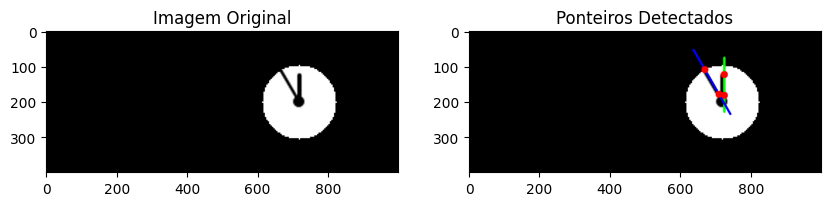

Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png


In [76]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Ponteiros Detectados")
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

plt.show()

print("Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png")

Ângulo 1: 104.28 graus
Ângulo 2: 38.72 graus
Ângulo 3: 37.00 graus
276.8247351412457
Horário detectado: 09:44


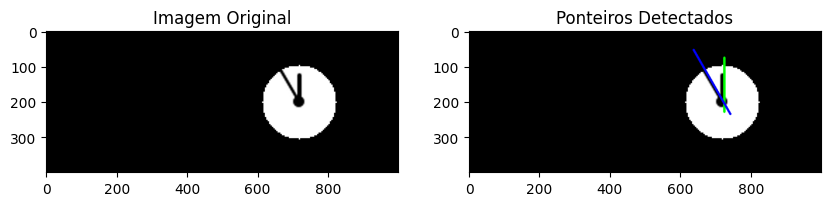

Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "clock_1.png"

imagem = cv2.imread(image_path, cv2.IMREAD_COLOR)

cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

suave = cv2.medianBlur(cinza, 5)

circulos = cv2.HoughCircles(
    suave,
    cv2.HOUGH_GRADIENT,
    dp=1.2,  
    minDist=40,  
    param1=50,  
    param2=30,  
    minRadius=15,  
    maxRadius=60,  
)

vertices = []

if circulos is not None:
    circulos = np.round(circulos[0, :]).astype("int")

    x, y, raio = circulos[0]

    mask = np.zeros_like(cinza)
    cv2.circle(mask, (x, y), int(raio * 0.70), 255, -1)

    masked_image = cv2.bitwise_and(imagem, imagem, mask=mask)

    x1, y1 = x - int(raio * 0.80), y - int(raio * 0.80)
    x2, y2 = x + int(raio * 0.80), y + int(raio * 0.80)
    cropped_image = masked_image[y1:y2, x1:x2]

    scale_factor = 4  
    width = int(imagem.shape[1] * scale_factor)
    height = int(imagem.shape[0] * scale_factor)
    high_quality_image = cv2.resize(imagem, (width, height), interpolation=cv2.INTER_CUBIC)
    high_quality_gray = cv2.cvtColor(high_quality_image, cv2.COLOR_BGR2GRAY)
    high_quality_mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    high_quality_masked_image = cv2.bitwise_and(high_quality_image, high_quality_image, mask=high_quality_mask)

    gray = cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 75, 200, apertureSize=3)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=45, minLineLength=30, maxLineGap=10
    )

    line_image = np.copy(high_quality_masked_image)

    longest_line_minute = None
    max_length_minute = 0
    longest_line_hour = None
    max_length_hour = 0

    def line_length(x1, y1, x2, y2):
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def calculate_angle(x1, y1, x2, y2, cx, cy):
        angle = np.arctan2(y2 - cy, x2 - cx) - np.arctan2(y1 - cy, x1 - cx)
        angle = np.degrees(angle)
        if angle < 0:
            angle += 360
        return angle

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = line_length(x1, y1, x2, y2)
            thickness = cv2.norm(gray[y1:y2, x1:x2], cv2.NORM_L2) / length

            if thickness > 10:
                if length > max_length_hour:
                    max_length_hour = length
                    longest_line_hour = (x1, y1, x2, y2)
            else:
                if length > max_length_minute:
                    max_length_minute = length
                    longest_line_minute = (x1, y1, x2, y2)

        if longest_line_minute is not None:
            x1, y1, x2, y2 = longest_line_minute
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
            new_length = length * 1.8  
            x1_new = int(x1 - direction_vector[0] * (new_length - length))
            y1_new = int(y1 - direction_vector[1] * (new_length - length))
            x2_new = int(x2 + direction_vector[0] * (new_length - length))
            y2_new = int(y2 + direction_vector[1] * (new_length - length))
            cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 5)
            vertices.append((x1, y1))
            vertices.append((x2, y2))

        if longest_line_hour is not None:
            x1, y1, x2, y2 = longest_line_hour
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
            new_length = length * 1.8 
            x1_new = int(x1 - direction_vector[0] * (new_length - length))
            y1_new = int(y1 - direction_vector[1] * (new_length - length))
            x2_new = int(x2 + direction_vector[0] * (new_length - length))
            y2_new = int(y2 + direction_vector[1] * (new_length - length))
            cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (255, 0, 0), 5)
            vertices.append((x1, y1))
            vertices.append((x2, y2))

        if len(vertices) >= 3:
            def angle_between_points(p1, p2, p3):
                v1 = np.array(p1) - np.array(p2)
                v2 = np.array(p3) - np.array(p2)
                angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
                return angle

            angle1 = angle_between_points(vertices[0], vertices[1], vertices[2])
            angle2 = angle_between_points(vertices[1], vertices[2], vertices[0])
            angle3 = 180.0 - angle1 - angle2 

            print(f"Ângulo 1: {angle1:.2f} graus")
            print(f"Ângulo 2: {angle2:.2f} graus")
            print(f"Ângulo 3: {angle3:.2f} graus")
        else:
            print("Não há vértices suficientes para formar um triângulo.")

        def adjust_angle(angle):
            adjusted_angle = (angle - 90) % 360
            return adjusted_angle if adjusted_angle >= 0 else adjusted_angle + 360

        hour_angle = calculate_angle(*longest_line_hour, x, y) if longest_line_hour else 0
        minute_angle = calculate_angle(*longest_line_minute, x, y) if longest_line_minute else 0

        adjusted_hour_angle = adjust_angle(hour_angle)
        adjusted_minute_angle = adjust_angle(minute_angle)

        print(adjusted_hour_angle)
        hour = int(adjusted_hour_angle / 30)
        minute = int(adjusted_minute_angle / 6)

        print(f"Horário detectado: {hour:02d}:{minute:02d}")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Imagem Original")
    plt.imshow(cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Ponteiros Detectados")
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

    plt.show()

    print("Círculo preto detectado e imagem recortada salva como circulo_recortado_redimensionado.png")
else:
    print("Nenhum círculo detectado")
